# My Transport Calc from ASV data vs Transport from Marion's Data
*Akira Di Sandro, 6/27/20*
<br>
In this notebook, I will be using the function from ASV_trapz.ipynb to plot my calculated version of transport plotted against the figures I've made in obs_fig.ipynb.

## 1. Load in Data

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import random

In [15]:
from scipy.io import loadmat
x = loadmat('../SolomonStrait_westernXsection_linear2bot_sat4surf.mat')
y = loadmat('../allTransport_SolomonStrait.mat')

## 2. Save Data into variables

In [16]:
#along strait velocity saved in 255x99x590 matrix (depth x points along cross section x timestamps)
asv = x['ASV']  #asv is in m/s

#lon: lon points along cross section, lat (same as lon), xdist: distance from start of cross section
lon = x['bathy'][0][0][2][0]
lat = x['bathy'][0][0][3][0]
xdist = x['bathy'][0][0][4][0] #xdist is in km

#raw_time: datenums associated to each day mooring data was taken
raw_time = x['time'][0]

#depth: array of all the depths possible
depth = x['z'][:,0]  # depth is in m

To put everything in terms of meters, we have to do the following conversions. ASV is already in m/s and depth is already in m so all we need to do is change the units of xdist from km to m.

In [17]:
xdist = xdist * (10**3)

## 3. Make function that calculates Transport for the time-stamp you give it

I'm going to use all the code above to make a function that spits out Transport. For this calculation to work, everything has to be in the proper units (m). This function takes in four variables:
1. asv : along strait velocity, in the for of a 3D array (depth x points on cross section x time)
2. tstep : 1D array of time stamps
3. depth : 1D array of the different depths
4. dist : 1D array of the distance between point to point along the cross section
<br> 
This function returns the value of transport in Sv.

In [18]:
def calc_trans(asv, tstep, depth, dist):
    time = asv[:,:,tstep]
    horz_int = []
    for row in range(time.shape[0]):
        t0row = time[row]
        nans = np.isnan(t0row)
        t0row[nans] = 0
        row_int = np.trapz(t0row, xdist)
        horz_int = np.append(horz_int, [row_int])
    transport = np.trapz(horz_int, depth)
    transport = transport*(10**-6)
    return(transport)

## 4. Plot Transport time series

In [19]:
datenums = y['time'][0]
# this line below reads matlab datenums and returns datetime in human legible format
timestamps = pd.to_datetime(datenums-719529, unit='D')
# this code reads matlab datenums and returns it in a datetime vector. 
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

In [20]:
py_dt = []

for time in datenums:
    py_dt = np.concatenate([py_dt, [matlab2datetime(int(time))]])

In [21]:
my_trans = []
for i in range(asv.shape[2]):
    my_trans = np.append(my_trans, calc_trans(asv, i, depth, xdist))

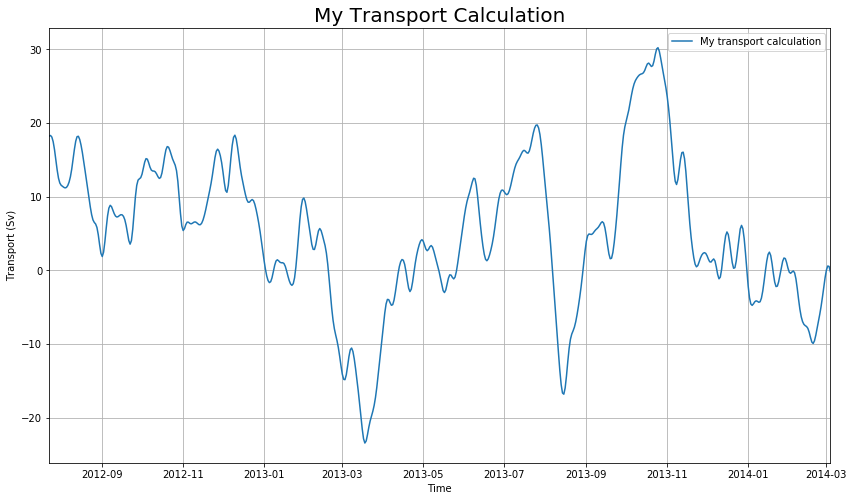

In [22]:
label = 'My transport calculation'
fig, ax = plt.subplots(figsize=(14,8))
ax.set_ylabel('Transport (Sv)')
ax.set_xlabel('Time')
ax.plot(py_dt, my_trans, label=label)
ax.legend()
ax.set_xlim(py_dt[0], py_dt[-1])
ax.grid(True)
plt.title('My Transport Calculation', fontsize=20)
plt.show()

## 5. Comparing my transport calculations to Marion's

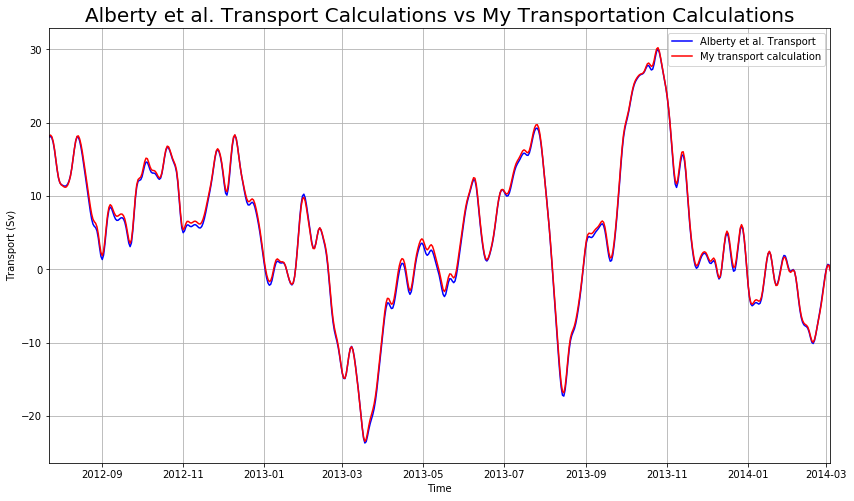

In [23]:
transport = y['T'][42]
label1 = 'Alberty et al. Transport'
label2 = 'My transport calculation'
fig, ax = plt.subplots(figsize=(14,8))
ax.set_ylabel('Transport (Sv)')
ax.set_xlabel('Time')
ax.plot(py_dt, transport, 'b', label=label1)
ax.plot(py_dt, my_trans, 'r', label=label2)
ax.legend()
ax.set_xlim(py_dt[0], py_dt[-1])
ax.grid(True)
plt.title('Alberty et al. Transport Calculations vs My Transportation Calculations', fontsize=20)
plt.show()

## 6. Monthly average of my Transport calculations

In [24]:
mon_times = []   #21 months total
for i in range(2012,2015):
    for j in range(1,13):
        if i == 2012 and j < 7:
            pass
        elif i == 2014 and j > 3:
            pass
        else:
            mon_times = np.append(mon_times, dt.datetime(i,j,1))

In [25]:
indices = []
for i in range(len(py_dt)):
    if py_dt[i] == dt.datetime(2012,7,23):
        indices = np.append(indices, i)
    for j in range(2012,2015):
        for k in range(1,13):
            if py_dt[i] == dt.datetime(j,k,1):
                indices = np.append(indices, i)

In [26]:
mon_trans = np.zeros(21)
for j in range(len(indices)):
    for i in range(len(my_trans)):
        if j == 20:
            if indices[j] <= i < 590:
                mon_trans[j] += my_trans[i]
        else:
            if indices[j] <= i < indices[j+1]:
                mon_trans[j] += my_trans[i]
    if j == 20:
        mon_trans[j] = mon_trans[j]/(590-indices[j])
    else:
        mon_trans[j] = mon_trans[j]/(indices[j+1]-indices[j])

array([ 15.7128885 ,  11.49492176,   7.21986658,  13.64791665,
         9.31420499,  11.27153761,   1.2155269 ,   0.22930749,
       -16.18329364,  -1.24636656,   0.97466949,   7.36294876,
        15.20113377,  -5.26480798,   6.84183883,  26.45247759,
         9.56971848,   2.18723116,  -1.38044347,  -5.21284972,
         0.22822845])

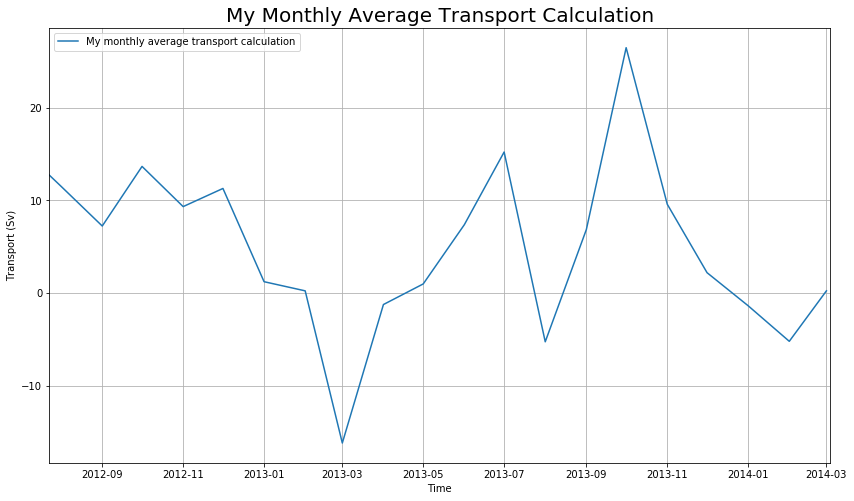

In [28]:
label = 'My monthly average transport calculation'
fig, ax = plt.subplots(figsize=(14,8))
ax.set_ylabel('Transport (Sv)')
ax.set_xlabel('Time')
ax.plot(mon_times, mon_trans, label=label)
ax.legend()
ax.set_xlim(py_dt[0], py_dt[-1])
ax.grid(True)
plt.title('My Monthly Average Transport Calculation', fontsize=20)
plt.show()